In [10]:
import torch
import zuko
import matplotlib.pyplot as plt
from zuko.flows import Flow, UnconditionalDistribution, UnconditionalTransform
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.distributions import DiagNormal
from zuko.transforms import RotationTransform


# Probability in PyTorch

## Distributions

From zuko tutorials on PyTorch distributions: https://zuko.readthedocs.io/stable/tutorials/basics.html

Distributions are mathematical objects defined in pytorch: we can sample from them or we can get the log probability of points.

In [3]:
distribution = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

x = distribution.sample()  # x ~ p(X)
log_p = distribution.log_prob(x)  # log p(X = x)

x, log_p

(tensor(0.7882), tensor(-1.2296))

## Transformations

Transformations are invertible functions applied to probability distribution. 
The determinant of the jacobian needs to be available to be able to transforms p.d.f

In [4]:
transform = torch.distributions.AffineTransform(torch.tensor(2.0), torch.tensor(3.0))

x = distribution.sample()  # x ~ p(X)
y = transform(x)  # f(x)
xx = transform.inv(y)  # f^{-1}(f(x))
ladj = transform.log_abs_det_jacobian(x, y)  # log |det df(x)/dx|

y, xx, ladj

(tensor(5.7848), tensor(1.2616), tensor(1.0986))

# Normalizing Flows

A Normalizing Flows (NF) is a set of invertible transformations that brings a complex p.d.f to a simple base distribution (usually a gaussian). 
- We can sample points from p.d.f represented by the NF, sampling from the base distribution and tranforming them. 
- We can compute the log_prob of samples by bringing the point to the base distribution and using the base pdf and the detJacobian of the transformations. 

In [5]:
flow = zuko.distributions.NormalizingFlow(transform, distribution)

x = flow.sample()
log_p = flow.log_prob(x)

x, log_p

(tensor(-0.7271), tensor(0.1632))

The set of transformations makes possible to create complex pdf.

The transformations list is always considered in the **normalizing direction**: from the output pdf to the base distribution

In [7]:
flow = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=2, hidden_features=(64, 64)),
        UnconditionalTransform(RotationTransform, torch.randn(2, 2)),
        MaskedAutoregressiveTransform(features=2, hidden_features=(64, 64)),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(2),
        torch.ones(2),
        buffer=True,
    ),
)

In [8]:
y =  flow().sample((10000,))

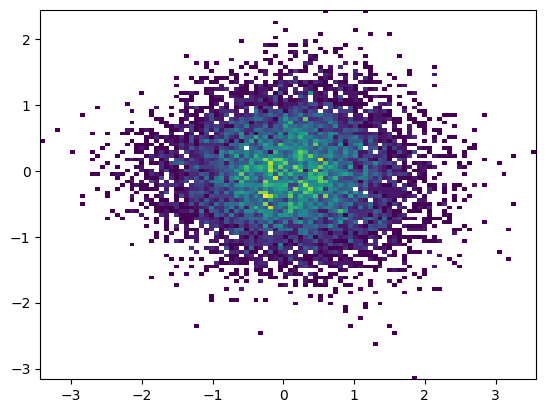

In [18]:
plt.hist2d(y[:,0], y[:,1], bins =100, cmin=1);

## Conditional probability
The transformations can be conditional on external tensors. We can model $p(x|c)$. 

In [19]:
flow_conditional = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=2, context=2, hidden_features=(64, 64)),
        UnconditionalTransform(RotationTransform, torch.randn(2, 2)),
        MaskedAutoregressiveTransform(features=2, context=2, hidden_features=(64, 64)),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(2),
        torch.ones(2),
        buffer=True,
    ),
)

We can sample 1 event for each conditioning entry.

In [25]:
c = torch.rand((10000, 2))
y =  flow_conditional(c).sample((1,))
y.shape

torch.Size([1, 10000, 2])

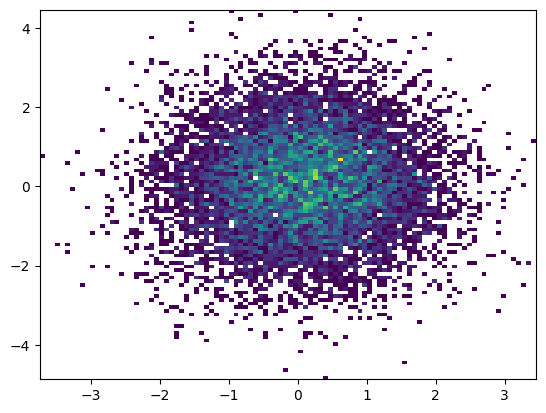

In [28]:
plt.hist2d(y[0,:,0], y[0,:,1], bins =100, cmin=1);

We can sample multiple event for each conditioning entry. (Be careful with memory!)

In [30]:
c = torch.rand((10000, 2))
y =  flow_conditional(c).sample((10,))
y.shape

torch.Size([10, 10000, 2])

In [32]:
y[:,:,0]

tensor([[-1.2629, -0.2272, -0.6104,  ..., -1.3330, -0.3332,  0.1660],
        [-1.0601, -0.9651,  0.1611,  ..., -0.3777, -0.8926, -0.8387],
        [ 0.7157,  1.2782,  0.2620,  ..., -0.8038,  0.1791,  0.2666],
        ...,
        [ 0.0347, -0.3303,  1.9848,  ...,  1.1294,  0.7180,  0.5963],
        [ 0.7005,  0.0434, -0.6915,  ..., -0.5448, -1.4598,  0.9003],
        [-1.0483,  0.2439,  0.1109,  ..., -0.9714, -0.5748,  0.2156]])

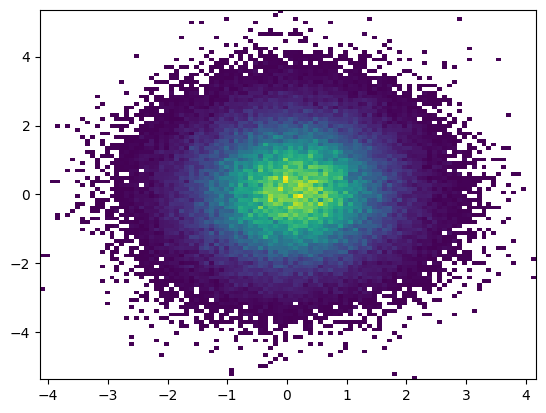

In [34]:
plt.hist2d(y[:,:,0].flatten(), y[:,:,1].flatten(), bins =100, cmin=1);